In [61]:
"""
Training MobileNetV2 models and re-training the classifier.
Authors: Paul Rosero & Booy Faassen
"""

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn import metrics
import psutil
import seaborn as sns
import pandas as pd
import pathlib
from datetime import datetime
import os

tf.get_logger().setLevel('ERROR') #disable info and warning messages from Tensorflow. Still shows error messages.

In [62]:
#Define some parameters for the loader:
img_height = 224
img_width = 224
root_dir = './data/augmented'
class_names=["0.0", "1.0"]

In [63]:
""" Loading the data """

def split_train_test_set(dataset, bs):
    train_dir=root_dir +"/" + dataset +"/" + "train"
    test_dir=root_dir + "/" + dataset +"/" + "test"
    # Import data from directories and turn it into batches
    train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     labels='inferred',
                                                                     seed=123,
                                                                     label_mode="categorical",
                                                                     color_mode='rgb',
                                                                     batch_size=bs, # number of images to process at a time 
                                                                     image_size=(img_height, img_width)
                                                                    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    labels='inferred',
                                                                    seed=123,
                                                                    label_mode="categorical",
                                                                    color_mode='rgb',
                                                                    batch_size=bs, # number of images to process at a time 
                                                                    image_size=(img_height, img_width)   
                                                                   )
    return train_data, test_data

In [64]:
""" Set metrics for later use """

METRICS = [
    tf.keras.metrics.Accuracy(name='acc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [65]:
def build_model(num_classes, model_path, metrics=METRICS):
    inputs = tf.keras.layers.Input(shape=(img_height,img_width,3))
    model = MobileNetV2(include_top=False, input_tensor=inputs, weights=model_path)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="MobileNetV2")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # I set learning rate to 0.001
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
    )
    return model

In [66]:
""" Training """

def train(model_path, num_epochs):
    model = build_model(num_classes=2, model_path=model_path, metrics=METRICS)
    start=datetime.now()
    hist_m = model.fit(train_data,
                epochs=num_epochs,
                steps_per_epoch=len(train_data),
                validation_data=test_data,
                # Go through less of the validation data so epochs are faster (we want faster experiments!)
                validation_steps=int(0.25 * len(test_data)),
                verbose=1 )
    end=datetime.now()

    # find difference loop start and end time and display
    td= (end-start)
    print("----------------- MODEL----------------------------")
    print(f"The time of execution of above program is : {td}ms")
    # Calling psutil.cpu_precent()for 4 seconds
    print('The CPU usage is: ', psutil.cpu_times_percent(5))
    # Getting % usage of virtual_memory ( 3rd field)
    print('RAM memory % used:', psutil.virtual_memory()[2])
    # Getting usage of virtual_memory in GB ( 4th field)
    print('RAM Used (GB):',psutil.virtual_memory()[3]/1000000000)
    print("---------------------------------------------------")

In [67]:
"""
Evaluate the model with the test set.
Returns a list of all actual labels and predicted labels, respectively.
"""

def evaluate_model(model, test_data):
    
    img_batch, label_batch = iter(test_data).next()
    
    label_list = []
    prediction_list = []
    
    for i in range(len(label_batch)):
        label_list.append(int(label_batch.numpy()[i][1]))

    # Run predictions on every image in test_data.
    preds = model.predict(img_batch.numpy(), verbose=0)
    for i in range(len(preds)):
        prediction_list.append(round(preds[i][1]))

    return label_list, prediction_list

In [68]:
"""
Plots the confusion matrixs for a given list of actual labels and corresponding predictions.
Partially copied from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics
"""

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions) # predictions > p) # I took this out
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p)) # I am not sure if it actually evaluates at 0.5...?
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives:', cm[0][0])
    print('False Positives:', cm[0][1])
    print('False Negatives:', cm[1][0])
    print('True Positives:', cm[1][1])
    print('Accuracy:', ((cm[0][0]+cm[1][1]) / (cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])))
    print('Recall:', (cm[1][1]/(cm[1][1]+cm[1][0])))
    print('Precision:', (cm[1][1]/(cm[1][1]+cm[0][1]))) 

In [69]:
""" Re-train for 5 epochs, save model, run inference """

def compute(model_name, dataset):
    model_path = '../../Results/mobilenet/mobilenet/' + model_name
    train_data, test_data = split_train_test_set(dataset, bs=32)
    
    train(model_path=model_path, num_epochs=5)
    
    print('accuracy:', hist_m.history['accuracy'][num_epochs-1])
    
    model.save('../../Results/mobilenet/mobilenet_retrained/' + model_name + '_v2')
    
    new_batch_size = len(os.listdir('./data/augmented/'+dataset+'/test/0.0')) + len(os.listdir('./data/augmented/'+dataset+'/test/1.0'))
    print(new_batch_size)
    
    """To run plot_CM"""

    train_ds, test_ds = split_train_test_set(dataset, bs=new_batch_size) # make sure bs = lenth of test set
    label_list, prediction_list = evaluate_model(model, test_ds)
    plot_cm(label_list, prediction_list)

Found 2231 files belonging to 2 classes.
Found 747 files belonging to 2 classes.
Epoch 1/5
70/70 [==============================] - 71s 925ms/step - loss: 0.5802 - acc: 0.0000e+00 - tp: 1662.0000 - fp: 761.0000 - tn: 1662.0000 - fn: 761.0000 - accuracy: 0.6859 - precision: 0.6859 - recall: 0.6859 - auc: 0.7612 - prc: 0.7628 - val_loss: 2.4128 - val_acc: 0.0000e+00 - val_tp: 89.0000 - val_fp: 103.0000 - val_tn: 89.0000 - val_fn: 103.0000 - val_accuracy: 0.4635 - val_precision: 0.4635 - val_recall: 0.4635 - val_auc: 0.5819 - val_prc: 0.6042
Epoch 2/5
70/70 [==============================] - 59s 847ms/step - loss: 0.5348 - acc: 0.0000e+00 - tp: 1622.0000 - fp: 609.0000 - tn: 1622.0000 - fn: 609.0000 - accuracy: 0.7270 - precision: 0.7270 - recall: 0.7270 - auc: 0.8048 - prc: 0.8047 - val_loss: 1.3508 - val_acc: 0.0000e+00 - val_tp: 87.0000 - val_fp: 105.0000 - val_tn: 87.0000 - val_fn: 105.0000 - val_accuracy: 0.4531 - val_precision: 0.4531 - val_recall: 0.4531 - val_auc: 0.6032 - val_prc

747
Found 2231 files belonging to 2 classes.
Found 747 files belonging to 2 classes.
True Negatives: 257
False Positives: 120
False Negatives: 96
True Positives: 274
Accuracy: 0.7108433734939759
Recall: 0.7405405405405405
Precision: 0.6954314720812182


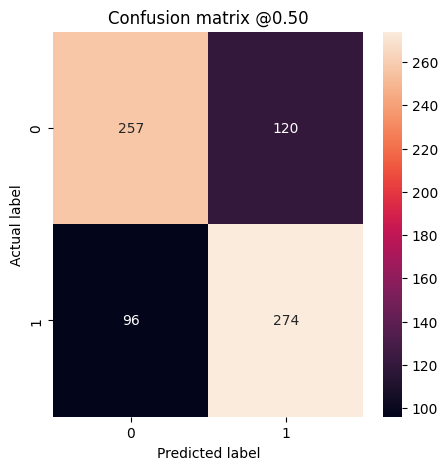

In [73]:
compute('mobilenet_test3_dataset06', 'dataset06_aug')